https://discourse.julialang.org/t/ode-solvers-why-is-matlab-ode45-uncannily-stable/63052/15

In [1]:
using DifferentialEquations
using Plots

In [2]:
function wk5!(dP, P, params, t)

    #=

    The 5-Element WK with serial L
    set Ls = 0 for 4-Element WK parallel

    Formulation for DifferentialEquations.jl

    P:          solution vector (pressures p1 and p2)
    params: parameter tuple
                (Rc, Rp, C, Lp, Ls, I, q)


    I need to find a way to tranfer the function name as well
    for the time being we have to have the function in "I"

    =#

    # Split parameter tuple:
    Rc, Rp, C, Lp, Ls, I, q = params

    dP[1] = (
        -Rc / Lp * P[1]
        + (Rc / Lp - 1 / Rp / C) * P[2]
        + Rc * (1 + Ls / Lp) * didt(I, t, q)
        + I(t, q) / C
        )

    dP[2] = -1 / Rp / C * P[2] + I(t, q) / C

    return

end

wk5! (generic function with 1 method)

In [3]:
# Generic Input Waveform
# max volume flow in ml/s
max_i = 425

# min volume flow in m^3/s
min_i = 0.0

T = 0.9

# Syst. Time in s
systTime = 2 / 5 * T

# Dicrotic notch time
dicrTime = 0.02

q_generic = (max_i, min_i, T, systTime, dicrTime)

function I_generic(t, q_generic)
    max_i, min_i, T, systTime, dicrTime = q_generic
    # implicit conditional using boolean multiplicator
    # sine waveform
    (
        (max_i - min_i) * sin(pi / systTime * (t % T))
        * (t % T < (systTime + dicrTime) )
        + min_i
    )
end

I_generic (generic function with 1 method)

In [4]:
function didt(I, t, q)
    dt = 1e-3;
    didt = (I(t+dt, q) - I(t-dt, q)) / (2 * dt)
    return didt
end

didt (generic function with 1 method)

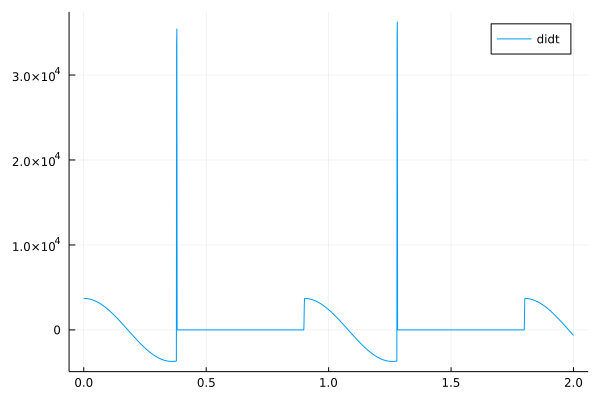

In [5]:
plot(range(0, 2; length=2000), t -> didt(I_generic, t, q_generic); label="didt")

In [6]:
# Initial condition and time span
P0 = [0.0, 0.0]
tspan = (0.0, 30.0)

# Set parameters for Windkessel Model
Rc = 0.033
Rp = 0.6
C = 1.25
# L for serial model!
Ls = 0.01
# L for parallel
Lp = 0.02

I = I_generic
q = q_generic

p5 = (Rc, Rp, C, Lp, Ls, I, q)

problem = ODEProblem(wk5!, P0, tspan, p5)

dtmax = 1e-4

@time solutionTsit = solve(problem); GC.gc()
@time solutionTsitLowdt = solve(problem, Tsit5(), dtmax=dtmax); GC.gc()
@time solutionBS3 = solve(problem, BS3()); GC.gc()
@time solutionBS3Lowdt = solve(problem, BS3(), dtmax=dtmax); GC.gc()
@time solutionDP5 = solve(problem,DP5()); GC.gc()
@time solutionDP5Lowdt = solve(problem,DP5(), dtmax=dtmax); GC.gc()
@time solutionStiff = solve(problem, alg_hints=[:stiff]); GC.gc()

 29.388959 seconds (56.95 M allocations: 3.348 GiB, 2.89% gc time, 2.23% compilation time)
  1.840871 seconds (4.81 M allocations: 397.101 MiB, 8.46% gc time, 70.51% compilation time)
  2.746681 seconds (4.95 M allocations: 287.073 MiB, 99.96% compilation time)
  0.234024 seconds (1.34 M allocations: 133.246 MiB, 15.62% compilation time)
  2.391469 seconds (4.93 M allocations: 287.553 MiB, 99.98% compilation time)
  0.373095 seconds (1.94 M allocations: 192.746 MiB, 11.08% compilation time)
 11.395456 seconds (26.18 M allocations: 1.625 GiB, 2.22% gc time, 2.03% compilation time)


In [7]:
@time solutionTsit = solve(problem); GC.gc()
@time solutionTsitLowdt = solve(problem, Tsit5(), dtmax=dtmax); GC.gc()
@time solutionBS3 = solve(problem, BS3()); GC.gc()
@time solutionBS3Lowdt = solve(problem, BS3(), dtmax=dtmax); GC.gc()
@time solutionDP5 = solve(problem,DP5()); GC.gc()
@time solutionDP5Lowdt = solve(problem,DP5(), dtmax=dtmax); GC.gc()
@time solutionStiff = solve(problem, alg_hints=[:stiff]); GC.gc()

  0.000408 seconds (1.88 k allocations: 195.938 KiB)
  0.349839 seconds (2.70 M allocations: 275.003 MiB)
  0.000939 seconds (3.96 k allocations: 444.500 KiB)
  0.186747 seconds (1.20 M allocations: 123.943 MiB)
  0.000301 seconds (1.09 k allocations: 113.859 KiB)
  0.325129 seconds (1.80 M allocations: 183.442 MiB)
  0.016856 seconds (104.41 k allocations: 4.175 MiB)


In [8]:
@show length(solutionTsit.t)
@show length(solutionTsitLowdt.t)
@show length(solutionBS3.t)
@show length(solutionBS3Lowdt.t)
@show length(solutionDP5.t)
@show length(solutionDP5Lowdt.t)
@show length(solutionStiff.t);

length(solutionTsit.t) = 192
length(solutionTsitLowdt.t) = 300010
length(solutionBS3.t) = 976
length(solutionBS3Lowdt.t) = 300034
length(solutionDP5.t) = 173
length(solutionDP5Lowdt.t) = 300002
length(solutionStiff.t) = 3992


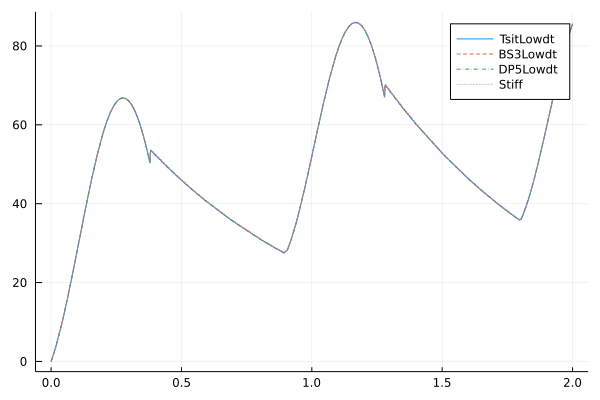

In [9]:
a, b = 0, 2

plot()
#plot!(t -> solutionTsit(t; idxs=1), a, b; label="Tsit")
plot!(t -> solutionTsitLowdt(t; idxs=1), a, b; label="TsitLowdt")
#plot!(t -> solutionBS3(t; idxs=1), a, b; label="BS3", ls=:dash)
plot!(t -> solutionBS3Lowdt(t; idxs=1), a, b; label="BS3Lowdt", ls=:dash)
#plot!(t -> solutionDP5(t; idxs=1), a, b; label="DP5", ls=:dashdot)
plot!(t -> solutionDP5Lowdt(t; idxs=1), a, b; label="DP5Lowdt", ls=:dashdot)
plot!(t -> solutionStiff(t; idxs=1), a, b; label="Stiff", ls=:dot, lw=1.5)

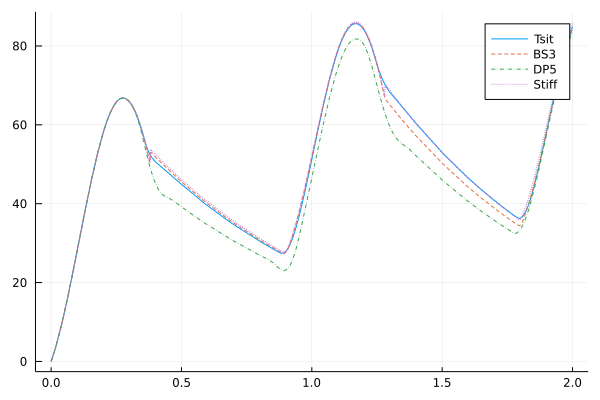

In [10]:
a, b = 0, 2

plot()
plot!(t -> solutionTsit(t; idxs=1), a, b; label="Tsit")
#plot!(t -> solutionTsitLowdt(t; idxs=1), a, b; label="TsitLowdt")
plot!(t -> solutionBS3(t; idxs=1), a, b; label="BS3", ls=:dash)
#plot!(t -> solutionBS3Lowdt(t; idxs=1), a, b; label="BS3Lowdt", ls=:dash)
plot!(t -> solutionDP5(t; idxs=1), a, b; label="DP5", ls=:dashdot)
#plot!(t -> solutionDP5Lowdt(t; idxs=1), a, b; label="DP5Lowdt", ls=:dashdot)
plot!(t -> solutionStiff(t; idxs=1), a, b; label="Stiff", ls=:dot, lw=1.5)

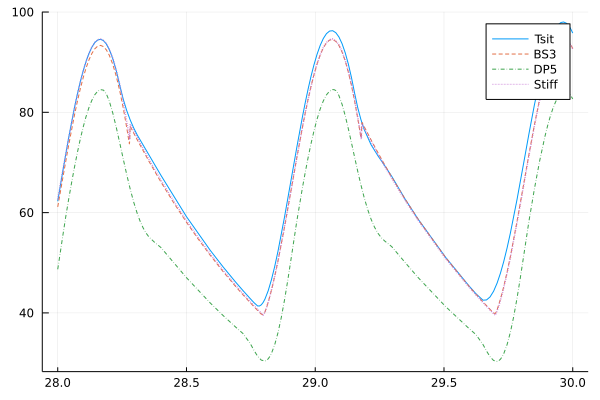

In [11]:
a, b = 28, 30

plot()
plot!(t -> solutionTsit(t; idxs=1), a, b; label="Tsit")
#plot!(t -> solutionTsitLowdt(t; idxs=1), a, b; label="TsitLowdt")
plot!(t -> solutionBS3(t; idxs=1), a, b; label="BS3", ls=:dash)
#plot!(t -> solutionBS3Lowdt(t; idxs=1), a, b; label="BS3Lowdt", ls=:dash)
plot!(t -> solutionDP5(t; idxs=1), a, b; label="DP5", ls=:dashdot)
#plot!(t -> solutionDP5Lowdt(t; idxs=1), a, b; label="DP5Lowdt", ls=:dashdot)
plot!(t -> solutionStiff(t; idxs=1), a, b; label="Stiff", ls=:dot, lw=1.5)